In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from pyts.classification import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import gc

from tslearn.piecewise import PiecewiseAggregateApproximation
from IPython.display import Audio
from tqdm.notebook import tqdm
from pyts.transformation import ShapeletTransform

## Data preparation

In [2]:
#X = np.load("DATASETS/TimeSeriesTrimmed_Downsapled/X_100.npy")
X = np.load("DATASETS/TimeSeriesTrimmed_Downsapled/X_10.npy")
y = pd.read_csv("DATASETS/TimeSeriesTrimmed_Downsapled/y.csv")

np.nan_to_num(X,copy=False)
X.shape

(2452, 23962)

In [3]:
X_train = np.load("DATASETS/TimeSeriesTrimmed/RavdessTimeSeriesTrim_X_train.npy")
y_train = pd.read_csv("DATASETS/TimeSeriesTrimmed/RavdessTimeSeriesTrim_Y_train.csv")

X_test = np.load("DATASETS/TimeSeriesTrimmed/RavdessTimeSeriesTrim_X_test.npy")
y_test = pd.read_csv("DATASETS/TimeSeriesTrimmed/RavdessTimeSeriesTrim_Y_test.csv")

X=np.concatenate((X_train,X_test))
y=pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

del X_train,y_train,X_test,y_test
gc.collect()

np.nan_to_num(X,copy=False)
X.shape

(2452, 243200)

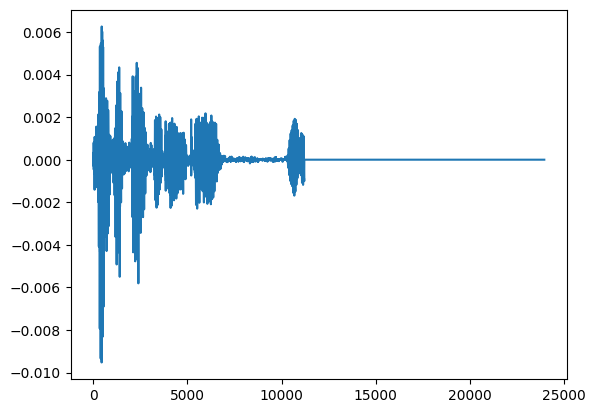

In [3]:
plt.plot(X[200])

In [3]:
emotion_mapper = {"neutral":0, "calm":1, "happy":2, "sad":3, "angry":4, "fearful":5, "disgust":6, "surprised":7}
y = y["emotion"].replace(emotion_mapper)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
del X,y
gc.collect()

8

## Brute Force Approach

In [5]:
from pyts.transformation import ShapeletTransform

In [1]:
# Shapelet transformation
st = ShapeletTransform(
                        window_sizes=[200,300],
                        window_steps=[80,100],
                        sort=True,
                        verbose=60,
                        n_jobs=-1)
X_new = st.fit_transform(X_train, y_train)
X_test_new = st.transform(X_test)

NameError: name 'ShapeletTransform' is not defined

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_new, y_train)

y_pred = clf.predict(X_test_new)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

## Learning base

In [5]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [6]:
n_ts = len(X_train)
ts_sz = len(X_train[0])
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1716
ts_sz 23962
n_classes 8
shapelet_sizes {2396: 8}


In [14]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=10,
                        batch_size=128,
                        verbose=1,
                       scale=True)

In [15]:
shp_clf.fit(X_train, y_train)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_9/false_conv_0_0/Conv1D' defined at (most recent call last):
    File "D:\Python\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Python\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Python\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Python\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "D:\Python\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "D:\Python\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "D:\Python\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\Python\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\Python\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Python\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "D:\Python\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "D:\Python\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "D:\Python\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\Python\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\Python\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\Python\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Python\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\andri\AppData\Local\Temp\ipykernel_17844\5649822.py", line 1, in <module>
      shp_clf.fit(X_train, y_train)
    File "D:\Python\lib\site-packages\tslearn\shapelets\shapelets.py", line 446, in fit
      h = self.model_.fit(
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\Python\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\Python\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "D:\Python\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_9/false_conv_0_0/Conv1D'
OOM when allocating tensor with shape[256,1,21567,2396] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model_9/false_conv_0_0/Conv1D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4314]

In [ ]:
y_pred = shp_clf.predict(X_test)

In [26]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.1453804347826087
F1-score [0.07352941 0.         0.         0.17857143 0.         0.24924012
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.06      0.09      0.07        56
           1       0.00      0.00      0.00       113
           2       0.00      0.00      0.00       113
           3       0.18      0.18      0.18       113
           4       0.00      0.00      0.00       113
           5       0.15      0.73      0.25       113
           6       0.00      0.00      0.00        58
           7       0.00      0.00      0.00        57

    accuracy                           0.15       736
   macro avg       0.05      0.12      0.06       736
weighted avg       0.06      0.15      0.07       736



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Shaplet-distances-based Classifier

In [8]:
X_train2 = shp_clf.transform(X_train)

NotFittedError: This LearningShapelets instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [28]:
X_train2.shape

(1716, 7)

In [29]:
X_train2

array([[3.53272888e-03, 6.81889069e-04, 1.08080074e-01, ...,
        2.60097869e-02, 1.87468585e-02, 6.78090379e-04],
       [3.38563160e-03, 1.86169986e-04, 9.99013931e-02, ...,
        2.21096333e-02, 2.23598070e-02, 1.48776383e-03],
       [7.55271735e-03, 6.72082603e-03, 1.41179606e-01, ...,
        4.43552546e-02, 6.44763606e-03, 9.44448810e-04],
       ...,
       [3.00224330e-02, 2.25757286e-02, 2.09571403e-02, ...,
        4.83317330e-04, 9.28909108e-02, 3.99542116e-02],
       [4.15409356e-03, 2.09920065e-04, 8.33561420e-02, ...,
        1.46972146e-02, 3.13736647e-02, 4.37157927e-03],
       [3.23776826e-02, 3.34740803e-02, 2.19520822e-01, ...,
        9.76174921e-02, 5.27673168e-04, 1.79451015e-02]], dtype=float32)

In [30]:
X_test2 = shp_clf.transform(X_test)

2/2 [==============================] - 1s 487ms/step


In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train2, y_train)

KNeighborsClassifier()

In [33]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.10869565217391304
F1-score [0.11398964 0.16783217 0.1027668  0.12       0.1        0.09302326
 0.04444444 0.        ]
              precision    recall  f1-score   support

           0       0.08      0.20      0.11        56
           1       0.14      0.21      0.17       113
           2       0.09      0.12      0.10       113
           3       0.14      0.11      0.12       113
           4       0.11      0.09      0.10       113
           5       0.14      0.07      0.09       113
           6       0.06      0.03      0.04        58
           7       0.00      0.00      0.00        57

    accuracy                           0.11       736
   macro avg       0.10      0.10      0.09       736
weighted avg       0.11      0.11      0.10       736



In [34]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.14266304347826086
F1-score [0.03333333 0.17647059 0.24907063 0.03773585 0.07843137 0.05970149
 0.04651163 0.        ]
              precision    recall  f1-score   support

           0       0.25      0.02      0.03        56
           1       0.17      0.19      0.18       113
           2       0.16      0.59      0.25       113
           3       0.07      0.03      0.04       113
           4       0.15      0.05      0.08       113
           5       0.19      0.04      0.06       113
           6       0.04      0.05      0.05        58
           7       0.00      0.00      0.00        57

    accuracy                           0.14       736
   macro avg       0.13      0.12      0.09       736
weighted avg       0.13      0.14      0.10       736



## Feature-based Classifier

In [24]:
import scipy.stats as stats

In [25]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [26]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [27]:
X_train3.shape

(1716, 13)

In [28]:
X_train3

array([[ 2.40060149e-06,  1.67234119e-03,  2.79672507e-06, ...,
         1.43547352e-03,  9.14907781e-02,  8.96240632e+00],
       [ 5.31036763e-07,  9.46733917e-03,  8.96305110e-05, ...,
         5.60914481e-05,  1.88388516e-01,  4.82588967e+00],
       [ 2.25847604e-06,  1.20858479e-04,  1.46067719e-08, ...,
         1.86869475e-02,  1.01646615e+01,  4.16394985e+02],
       ...,
       [-1.08142449e-06,  1.58144238e-03,  2.50095999e-06, ...,
        -6.83821620e-04, -3.87241442e-02,  1.38437894e+01],
       [ 5.26218770e-05,  6.58299817e-03,  4.33358649e-05, ...,
         7.99360347e-03, -2.91228194e+00,  3.12241105e+01],
       [-2.03391126e-06,  3.47616104e-04,  1.20836955e-07, ...,
        -5.85102715e-03, -3.14561948e+00,  3.96349358e+01]])

In [29]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [30]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.13994565217391305
F1-score [0.         0.02797203 0.01639344 0.25572005 0.03305785 0.04225352
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.07      0.02      0.03       113
           2       0.11      0.01      0.02       113
           3       0.15      0.84      0.26       113
           4       0.25      0.02      0.03       113
           5       0.10      0.03      0.04       113
           6       0.00      0.00      0.00        58
           7       0.00      0.00      0.00        57

    accuracy                           0.14       736
   macro avg       0.09      0.11      0.05       736
weighted avg       0.10      0.14      0.06       736



## Time Series Classifier

In [17]:
clf = KNeighborsClassifier(n_neighbors=60, weights='uniform')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.1331521739130435
F1-score [0.         0.101983   0.         0.27777778 0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.07      0.16      0.10       113
           2       0.00      0.00      0.00       113
           3       0.17      0.71      0.28       113
           4       0.00      0.00      0.00       113
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00        57
           7       0.00      0.00      0.00        58

    accuracy                           0.13       736
   macro avg       0.03      0.11      0.05       736
weighted avg       0.04      0.13      0.06       736



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.21467391304347827
F1-score [0.         0.35955056 0.23673469 0.06666667 0.22222222 0.18930041
 0.         0.02531646]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.24      0.71      0.36       113
           2       0.22      0.26      0.24       113
           3       0.14      0.04      0.07       113
           4       0.30      0.18      0.22       113
           5       0.18      0.20      0.19       113
           6       0.00      0.00      0.00        57
           7       0.05      0.02      0.03        58

    accuracy                           0.21       736
   macro avg       0.14      0.18      0.14       736
weighted avg       0.17      0.21      0.17       736



## KNN with DTW

In [19]:
from pyts.classification import KNeighborsClassifier

In [ ]:
clf = KNeighborsClassifier(n_neighbors=30, metric='dtw_sakoechiba',n_jobs=-1)
clf.fit(X_train, y_train)


y_pred = list()
for ts in tqdm(X_test):
    ts_pred = clf.predict(ts.reshape(1,-1))
    y_pred.append(ts_pred)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

  0%|          | 0/736 [00:00<?, ?it/s]

## CNN Classifier

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization

In [7]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [8]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  4096
N. LABELS:  8


In [9]:
cnn = build_simple_cnn(n_timesteps, n_outputs)

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4089, 16)          144       
                                                                 
 batch_normalization (BatchN  (None, 4089, 16)         64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4089, 16)          0         
                                                                 
 dropout (Dropout)           (None, 4089, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4085, 32)          2592      
                                                                 
 batch_normalization_1 (Batc  (None, 4085, 32)         128       
 hNormalization)                                        

In [11]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [12]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

In [13]:
history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
86/86 [==============================] - 25s 277ms/step - loss: 1.9477 - accuracy: 0.2624 - val_loss: 2.0650 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - 23s 272ms/step - loss: 1.8776 - accuracy: 0.3010 - val_loss: 2.0709 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - 23s 270ms/step - loss: 1.8337 - accuracy: 0.2872 - val_loss: 2.0760 - val_accuracy: 0.1541 - lr: 0.0010
Epoch 4/5
86/86 [==============================] - 23s 272ms/step - loss: 1.7987 - accuracy: 0.3149 - val_loss: 2.0778 - val_accuracy: 0.1657 - lr: 0.0010
Epoch 5/5
86/86 [==============================] - 24s 277ms/step - loss: 1.7578 - accuracy: 0.3163 - val_loss: 2.0628 - val_accuracy: 0.2267 - lr: 0.0010


In [14]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

23/23 [==============================] - 2s 63ms/step
Accuracy 0.2105978260869565
F1-score [0.         0.43672457 0.         0.21383648 0.         0.16107383
 0.         0.18269231]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.30      0.78      0.44       113
           2       0.00      0.00      0.00       113
           3       0.37      0.15      0.21       113
           4       0.00      0.00      0.00       113
           5       0.33      0.11      0.16       113
           6       0.00      0.00      0.00        58
           7       0.11      0.67      0.18        57

    accuracy                           0.21       736
   macro avg       0.14      0.21      0.12       736
weighted avg       0.16      0.21      0.14       736



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
cnn.evaluate(X_test_cnn, y_test)

23/23 [==============================] - 2s 66ms/step - loss: 2.0655 - accuracy: 0.2106


[2.0655012130737305, 0.21059782803058624]

# LSTM Classifier

In [16]:
from keras.layers import LSTM

In [17]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
lstm = build_lstm(n_timesteps, n_outputs)

In [19]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 281,160
Trainable params: 281,160
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/10
86/86 [==============================] - 25s 291ms/step - loss: 1.7323 - accuracy: 0.3455 - val_loss: 2.0153 - val_accuracy: 0.1977 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 26s 298ms/step - loss: 1.7033 - accuracy: 0.3448 - val_loss: 1.9965 - val_accuracy: 0.2122 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - 28s 322ms/step - loss: 1.6658 - accuracy: 0.3739 - val_loss: 2.8404 - val_accuracy: 0.2035 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - 24s 274ms/step - loss: 1.6567 - accuracy: 0.3732 - val_loss: 2.6173 - val_accuracy: 0.2151 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - 22s 259ms/step - loss: 1.6337 - accuracy: 0.3717 - val_loss: 3.9568 - val_accuracy: 0.1744 - lr: 0.0010
Epoch 6/10
86/86 [==============================] - 22s 261ms/step - loss: 1.6095 - accuracy: 0.3819 - val_loss: 2.5976 - val_accuracy: 0.2064 - lr: 0.0010
Epoch 7/10
86/86 [==============================] - 22s 260ms/st

In [21]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

23/23 [==============================] - 52s 2s/step
Accuracy 0.07608695652173914
F1-score [0.14141414 0.         0.         0.         0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

           0       0.08      1.00      0.14        56
           1       0.00      0.00      0.00       113
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00       113
           4       0.00      0.00      0.00       113
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00        58
           7       0.00      0.00      0.00        57

    accuracy                           0.08       736
   macro avg       0.01      0.12      0.02       736
weighted avg       0.01      0.08      0.01       736



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
lstm.evaluate(X_test_cnn, y_test)

23/23 [==============================] - 53s 2s/step - loss: 2.0794 - accuracy: 0.0761


[2.0794413089752197, 0.07608695328235626]

In [ ]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)
X_train.shape

In [ ]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_train.shape

In [ ]:
y_train

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
X_train = X_train.reshape(40, 100, 6)
X_test = X_test.reshape(40, 100, 6)

In [ ]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)

In [ ]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

In [ ]:
lstm2.summary()

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
X_train_cnn.shape

In [ ]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

In [ ]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

In [ ]:
cnn2.summary()

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

In [ ]:
cnn3.summary()

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://pyts.readthedocs.io/en/stable/generated/pyts.multivariate.classification.MultivariateClassifier.html#pyts.multivariate.classification.MultivariateClassifier